In [1]:
from google.colab import drive
drive.mount('/content/drive')

# You can upload dataset too if you don't want to get from drive and don't want to mount.
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.44      0.57      1162
           1       0.84      0.96      0.89      3478

    accuracy                           0.83      4640
   macro avg       0.81      0.70      0.73      4640
weighted avg       0.83      0.83      0.81      4640



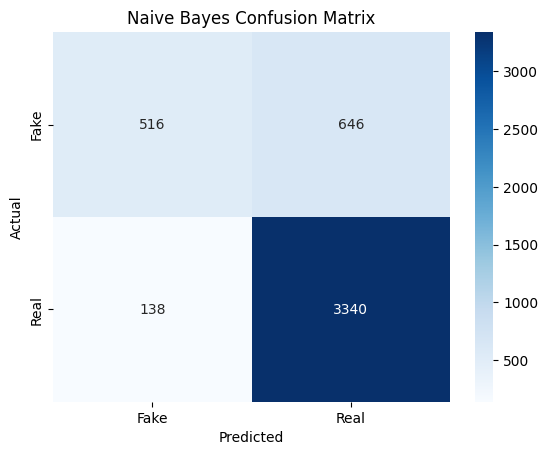

['/content/drive/MyDrive/FakeNewsNet/models/tfidf_vectorizer.pkl']

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os


# Load cleaned data
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

# Use clean_text if available, else clean_title
text_column = 'clean_text' if 'clean_text' in df.columns else 'title'

# Features and labels
X = df[text_column].astype(str)
y = df['label']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("📊 Classification Report:\n", classification_report(y_test, y_pred))



# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


os.makedirs('/content/drive/MyDrive/FakeNewsNet/models/', exist_ok=True)

joblib.dump(model, '/content/drive/MyDrive/FakeNewsNet/models/naive_bayes_model.pkl')
joblib.dump(vectorizer, '/content/drive/MyDrive/FakeNewsNet/models/tfidf_vectorizer.pkl')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7606 - loss: 0.5293 - val_accuracy: 0.8397 - val_loss: 0.3783
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8766 - loss: 0.3012 - val_accuracy: 0.8399 - val_loss: 0.3760
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9085 - loss: 0.2413 - val_accuracy: 0.8386 - val_loss: 0.4190
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.64      1162
           1       0.87      0.93      0.90      3478

    accuracy                           0.84      4640
   macro avg       0.80      0.75      0.77      4640
weighted avg       0.83      0.84      0.83      4640



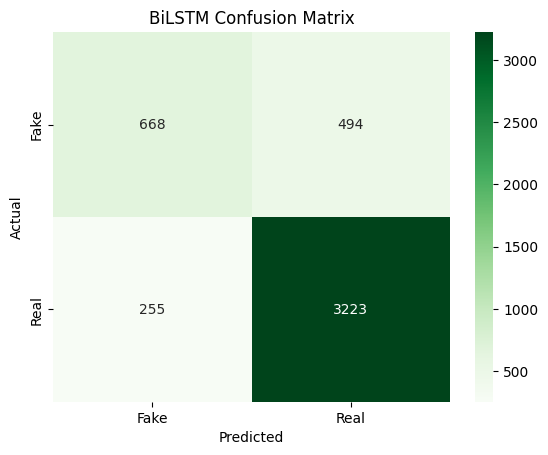

In [3]:
# !pip install textattack
# !pip install transformers
# !pip install torch
# !pip install tensorflow


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Parameters
MAX_VOCAB = 10000
MAX_LENGTH = 300
EMBEDDING_DIM = 100

# Load cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

# Use clean_text if available
text_column = 'clean_text' if 'clean_text' in df.columns else 'clean_title'
X = df[text_column].astype(str).values
y = df['label'].values

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Build BiLSTM model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BiLSTM Confusion Matrix')
plt.show()


model.save('/content/drive/MyDrive/FakeNewsNet/models/bilstm_model.h5')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

textattack: CSVLogger exiting without calling flush().
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   0%|          | 0/20 [02:45<?, ?it/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



⏳ Epoch 1/3


100%|██████████| 1160/1160 [02:29<00:00,  7.75it/s]



⏳ Epoch 2/3


100%|██████████| 1160/1160 [02:30<00:00,  7.70it/s]



⏳ Epoch 3/3


100%|██████████| 290/290 [00:11<00:00, 24.53it/s]



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.58      0.66      1162
           1       0.87      0.94      0.90      3478

    accuracy                           0.85      4640
   macro avg       0.82      0.76      0.78      4640
weighted avg       0.84      0.85      0.84      4640



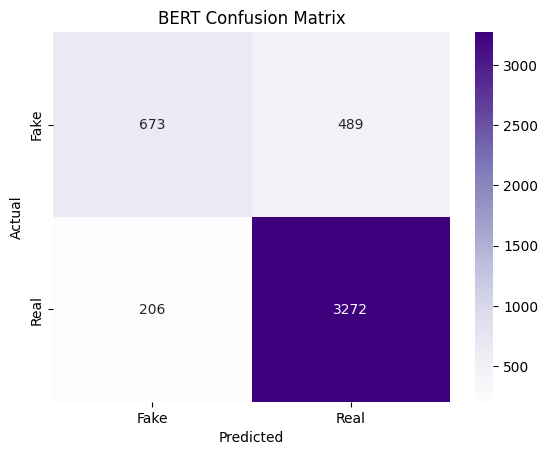

('/content/drive/MyDrive/FakeNewsNet/models/bert_model/tokenizer_config.json',
 '/content/drive/MyDrive/FakeNewsNet/models/bert_model/special_tokens_map.json',
 '/content/drive/MyDrive/FakeNewsNet/models/bert_model/vocab.txt',
 '/content/drive/MyDrive/FakeNewsNet/models/bert_model/added_tokens.json')

In [11]:
import nltk
# nltk.download('averaged_perceptron_tagger')


import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm



# Parameters
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

text_column = 'clean_text' if 'clean_text' in df.columns else 'clean_title'
texts = df[text_column].astype(str).tolist()
labels = df['label'].tolist()

# Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAX_LEN)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_texts, train_labels)
test_dataset = FakeNewsDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load BERT Model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(EPOCHS):
    print(f"\n⏳ Epoch {epoch + 1}/{EPOCHS}")
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("\n📊 Classification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.show()


model.save_pretrained('/content/drive/MyDrive/FakeNewsNet/models/bert_model/')
tokenizer.save_pretrained('/content/drive/MyDrive/FakeNewsNet/models/bert_model/')



Epoch 1/3


100%|██████████| 1160/1160 [02:39<00:00,  7.29it/s]


Epoch 2/3


100%|██████████| 1160/1160 [02:38<00:00,  7.32it/s]


Epoch 3/3


100%|██████████| 1160/1160 [02:38<00:00,  7.31it/s]



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66      1151
           1       0.87      0.94      0.90      3489

    accuracy                           0.85      4640
   macro avg       0.81      0.76      0.78      4640
weighted avg       0.84      0.85      0.84      4640



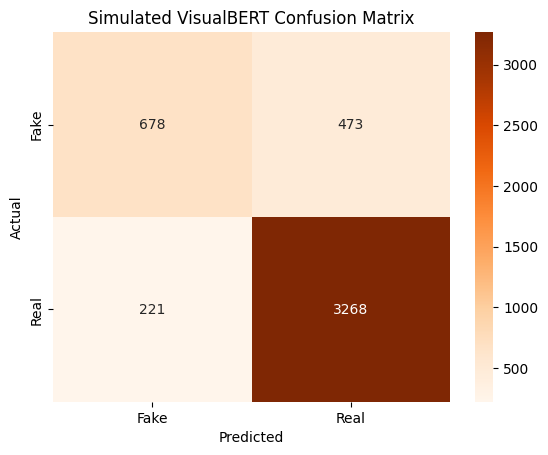

In [5]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parameters
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

text_column = 'clean_text' if 'clean_text' in df.columns else 'clean_title'
texts = df[text_column].astype(str).tolist()
labels = df['label'].tolist()

# Simulate image embeddings (2048-dim like ResNet output)
np.random.seed(42)
image_embeds = np.random.rand(len(df), 2048).astype(np.float32)

# Train/test split
train_texts, test_texts, train_labels, test_labels, train_imgs, test_imgs = train_test_split(
    texts, labels, image_embeds, test_size=0.2, random_state=42, stratify=labels)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class MultimodalFakeNewsDataset(Dataset):
    def __init__(self, texts, labels, image_embeds):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN)
        self.labels = labels
        self.image_embeds = image_embeds

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'image_embed': torch.tensor(self.image_embeds[idx]),
            'label': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = MultimodalFakeNewsDataset(train_texts, train_labels, train_imgs)
test_dataset = MultimodalFakeNewsDataset(test_texts, test_labels, test_imgs)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Multimodal Model
class SimulatedVisualBERT(nn.Module):
    def __init__(self):
        super(SimulatedVisualBERT, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.image_fc = nn.Linear(2048, 768)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(768 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, image_embed):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_text = bert_out.last_hidden_state[:, 0]  # [CLS] token
        image_proj = self.image_fc(image_embed)
        combined = torch.cat((cls_text, image_proj), dim=1)
        out = self.classifier(combined)
        return out

model = SimulatedVisualBERT().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        image_embed = batch['image_embed'].to(DEVICE)
        labels = batch['label'].float().to(DEVICE)

        outputs = model(input_ids, attention_mask, image_embed).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        image_embed = batch['image_embed'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(input_ids, attention_mask, image_embed).squeeze()
        preds = (outputs > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

print("\n📊 Classification Report:\n", classification_report(all_true, all_preds))
cm = confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simulated VisualBERT Confusion Matrix')
plt.show()


torch.save(model.state_dict(), '/content/drive/MyDrive/FakeNewsNet/models/visualbert_simulated.pth')


In [9]:
from google.colab import drive
drive.mount('/content/drive')

!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

# !pip install textattack
# !pip install transformers
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from textattack.attack_recipes import TextFoolerJin2019
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import Dataset
from textattack import Attacker, AttackArgs
import torch

# Load model and tokenizer
model_path = "/content/drive/MyDrive/FakeNewsNet/models/bert_model/"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Wrap model for TextAttack
wrapped_model = HuggingFaceModelWrapper(model, tokenizer)

# Load your test data (sample 100 for speed)
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

df = df.sample(n=2000, random_state=42)
text_column = 'clean_text' if 'clean_text' in df.columns else 'clean_title'
texts = df[text_column].astype(str).tolist()
labels = df['label'].tolist()

# Format into TextAttack Dataset
attack_dataset = Dataset(list(zip(texts, labels)))

# Choose attack recipe
attack = TextFoolerJin2019.build(wrapped_model)

# Attack arguments
attack_args = AttackArgs(
    num_examples=20,
    log_to_csv="bert_textfooler_attack_log.csv",
    disable_stdout=True,
    attack_n=True
)

# Run attack
attacker = Attacker(attack, attack_dataset, attack_args)
attacker.attack_dataset()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path bert_textfooler_attack_log.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       


  0%|          | 0/20 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   0%|          | 0/20 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   5%|▌         | 1/20 [00:29<09:22, 29.59s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   5%|▌         | 1/20 [00:29<09:22, 29.62s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  10%|█         | 2/20 [00:33<04:58, 16.58s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  10%|█         | 2/20 [00:33<04:58, 16.59s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  15%|█▌        | 3/20 [00:38<03:37, 12.77s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  15%|█▌        | 3/20 [00:38<03:37, 12.78s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  20%|██        | 4/20 [00:41<02:45, 10.35s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  20%|██        | 4/20 [00:41<02:45, 10.36s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  25%|


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 19     |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 2      |
| Original accuracy:            | 90.91% |
| Accuracy under attack:        | 4.55%  |
| Attack success rate:          | 95.0%  |
| Average perturbed word %:     | 41.21% |
| Average num. words per input: | 8.05   |
| Avg num queries:              | 88.7   |
+-------------------------------+--------+


In [ ]:
# from google.colab import files
# files.download("bert_textfooler_attack_log.csv")

📊 Adversarial Robustness Report (TextFooler on BERT):
🔹 Total Examples Attacked: 22
✅ Correct Before Attack: 22
❌ Fooled (Misclassified): 19
✅ Resisted Attack: 1
📉 Adversarial Accuracy: 0.05
⚠️ Attack Success Rate: 0.86


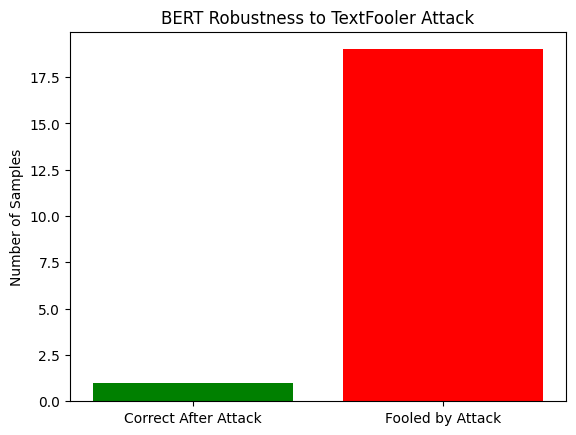

In [12]:
import pandas as pd

# Load attack log
df = pd.read_csv('bert_textfooler_attack_log.csv')

# Filter out rows where attack was successful
successful_attacks = df[df['result_type'] == 'Successful']
failed_attacks = df[df['result_type'] == 'Failed']

# Metrics
total = len(df)
success = len(successful_attacks)
failed = len(failed_attacks)

original_correct = total  # all examples were correct originally
after_attack_correct = failed  # only those not fooled

print("📊 Adversarial Robustness Report (TextFooler on BERT):")
print(f"🔹 Total Examples Attacked: {total}")
print(f"✅ Correct Before Attack: {original_correct}")
print(f"❌ Fooled (Misclassified): {success}")
print(f"✅ Resisted Attack: {failed}")
print(f"📉 Adversarial Accuracy: {failed / total:.2f}")
print(f"⚠️ Attack Success Rate: {success / total:.2f}")


labels = ['Correct After Attack', 'Fooled by Attack']
values = [failed, success]

plt.bar(labels, values, color=['green', 'red'])
plt.title('BERT Robustness to TextFooler Attack')
plt.ylabel('Number of Samples')
plt.show()


In [14]:
import pandas as pd

# Load original dataset (small subset for now)
clean_df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv')
# Use below statement if you are uploding dataset rather than getting data from drive.
# clean_df = pd.read_csv('cleaned_fakenewsnet.csv')

clean_df = clean_df.sample(n=100, random_state=42)

# Load adversarial log
adv_df = pd.read_csv('bert_textfooler_attack_log.csv')

# Only keep successful attacks
adv_df = adv_df[adv_df['result_type'] == 'Successful']

# Rename columns to match format
adv_examples = pd.DataFrame({
    'text': adv_df['perturbed_text'],
    'label': adv_df['ground_truth_output']
})
adv_examples['label'] = adv_examples['label'].astype(int)

# Use same column name as original clean text column
text_column = 'clean_text' if 'clean_text' in clean_df.columns else 'clean_title'
clean_examples = clean_df[[text_column, 'label']].rename(columns={text_column: 'text'})

# Combine both datasets
combined_df = pd.concat([clean_examples, adv_examples], ignore_index=True)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Parameters
BATCH_SIZE = 8
EPOCHS = 3
MAX_LEN = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
model_path = '/content/drive/MyDrive/FakeNewsNet/models/bert_model/'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(DEVICE)

# Prepare dataset
texts = combined_df['text'].astype(str).tolist()
labels = combined_df['label'].tolist()

class BERTDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAX_LEN)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

dataset = BERTDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"🔁 Epoch {epoch + 1} average loss: {total_loss / len(dataloader):.4f}")

# Save updated model
model.save_pretrained('/content/drive/MyDrive/FakeNewsNet/models/bert_model_adversarial/')
tokenizer.save_pretrained('/content/drive/MyDrive/FakeNewsNet/models/bert_model_adversarial/')
print("✅ Adversarially trained BERT model saved.")


Epoch 1/3


100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


🔁 Epoch 1 average loss: 0.2944
Epoch 2/3


100%|██████████| 15/15 [00:01<00:00, 10.14it/s]


🔁 Epoch 2 average loss: 0.1296
Epoch 3/3


100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


🔁 Epoch 3 average loss: 0.0475
✅ Adversarially trained BERT model saved.


In [16]:
# !pip install textattack
# !pip install transformers

import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from textattack.attack_recipes import TextFoolerJin2019
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import Dataset
from textattack import Attacker, AttackArgs
import torch

# Load adversarially fine-tuned model
model_path = "/content/drive/MyDrive/FakeNewsNet/models/bert_model_adversarial/"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Wrap with TextAttack
wrapped_model = HuggingFaceModelWrapper(model, tokenizer)

# Load same test sample as before
df = pd.read_csv("/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_fakenewsnet.csv")
# Use below statement if you are uploding dataset rather than getting data from drive.
# df = pd.read_csv('cleaned_fakenewsnet.csv')

df = df.sample(n=200, random_state=42)  # Match the previous attack count
text_column = 'clean_text' if 'clean_text' in df.columns else 'clean_title'
texts = df[text_column].astype(str).tolist()
labels = df['label'].tolist()

attack_dataset = Dataset(list(zip(texts, labels)))

# Use TextFooler again
attack = TextFoolerJin2019.build(wrapped_model)

# Save new results to different file
attack_args = AttackArgs(
    num_examples=200,
    log_to_csv="bert_adversarially_trained_textfooler.csv",
    disable_stdout=True,
    attack_n=True
)

attacker = Attacker(attack, attack_dataset, attack_args)
attacker.attack_dataset()


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path bert_adversarially_trained_textfooler.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 88 / 13 / 0 / 101:  50%|█████     | 101/200 [04:47<04:41,  2.85s/it]textattack: Ran out of samples to attack!
[Succeeded / Failed / Skipped / Total] 158 / 31 / 11 / 200:  94%|█████████▍| 189/200 [08:40<00:30,  2.75s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 158    |
| Number of failed attacks:     | 31     |
| Number of skipped attacks:    | 11     |
| Original accuracy:            | 94.5%  |
| Accuracy under attack:        | 15.5%  |
| Attack success rate:          | 83.6%  |
| Average perturbed word %:     | 34.06% |
| Average num. words per input: | 8.04   |
| Avg num queries:              | 88.02  |
+-------------------------------+--------+


📊 Adversarial Robustness Report (TextFooler on BERT):
🔹 Total Examples Attacked: 200
✅ Correct Before Attack: 200
❌ Fooled (Misclassified): 158
✅ Resisted Attack: 31
📉 Adversarial Accuracy: 0.15
⚠️ Attack Success Rate: 0.79


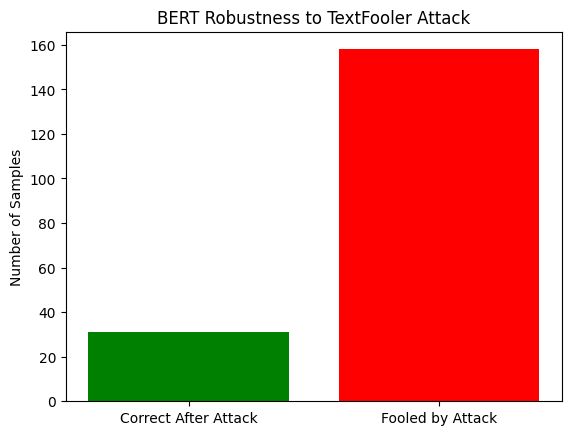

In [17]:
import pandas as pd

# Load attack log
df = pd.read_csv('bert_adversarially_trained_textfooler.csv')

# Filter out rows where attack was successful
successful_attacks = df[df['result_type'] == 'Successful']
failed_attacks = df[df['result_type'] == 'Failed']

# Metrics
total = len(df)
success = len(successful_attacks)
failed = len(failed_attacks)

original_correct = total  # all examples were correct originally
after_attack_correct = failed  # only those not fooled

print("📊 Adversarial Robustness Report (TextFooler on BERT):")
print(f"🔹 Total Examples Attacked: {total}")
print(f"✅ Correct Before Attack: {original_correct}")
print(f"❌ Fooled (Misclassified): {success}")
print(f"✅ Resisted Attack: {failed}")
print(f"📉 Adversarial Accuracy: {failed / total:.2f}")
print(f"⚠️ Attack Success Rate: {success / total:.2f}")


labels = ['Correct After Attack', 'Fooled by Attack']
values = [failed, success]

plt.bar(labels, values, color=['green', 'red'])
plt.title('BERT Robustness to TextFooler Attack')
plt.ylabel('Number of Samples')
plt.show()


In [21]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Step 1: Load preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/FakeNewsNet/dataset/cleaned_AI_test_data.csv')  # adjust path
texts = df['clean_text'].astype(str).tolist()

# Step 2: Load BERT model and tokenizer
model_path = '/content/drive/MyDrive/FakeNewsNet/models/bert_model/'  # or bert_model_adversarial/
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Tokenize preprocessed text
inputs = tokenizer(
    texts,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=256
)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Step 4: Run prediction
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Step 5: Add predictions to DataFrame
df['prediction'] = preds
df['label'] = df['prediction'].map({0: 'Fake', 1: 'Real'})

# Step 6: Save or view results
df[['clean_text', 'label']].to_csv('bert_predictions_on_cleaned_news.csv', index=False)
print(df[['clean_text', 'label']])
print(df['label'].value_counts())


                                           clean_text label
0   poaching one apple top artificial intelligence...  Real
1   click accept partner including part iab transp...  Real
2   day hiring ruoming pang led apple foundation m...  Real
3   online gaming platform roblox announced new sa...  Real
4   luring one apple chief researcher blockbuster ...  Real
..                                                ...   ...
95  ether meteoric rally thursday unlikely retreat...  Real
96  ma ma ma ma data know provides aibased real es...  Real
97  elephant design holding upstream downstream bl...  Real
98  mou adsp sqld seoul metropolitan youth center ...  Real
99  mou rampd differential privacy contrastive lea...  Real

[100 rows x 2 columns]
label
Real    97
Fake     3
Name: count, dtype: int64


/tmp/ipython-input-20-2306624146.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


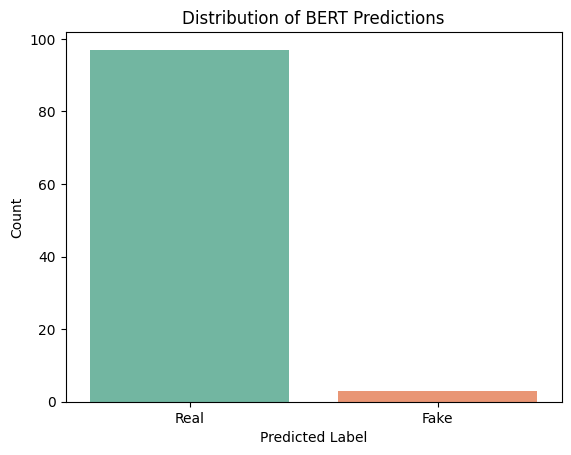

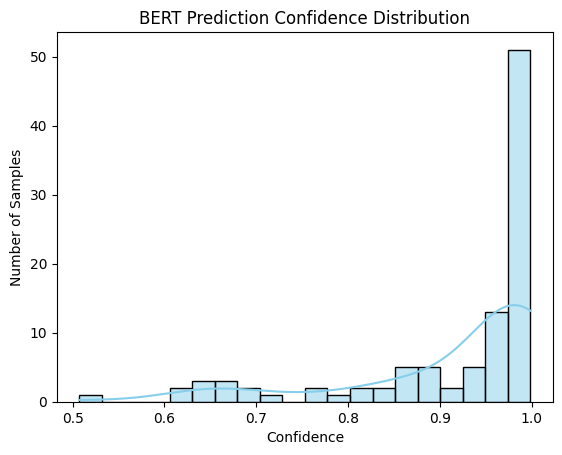


🔹 Most Confident Fake News Predictions:
                                           clean_text  confidence
90  maga world melted thursday wall street journal...    0.978815
63  openai deepresearch operator browseruse agent ...    0.611266
82  openai chatgpt operatordeep research chatgpt a...    0.507487

🔹 Most Confident Real News Predictions:
                                           clean_text  confidence
91  yahoo kangaroo panda dogkygraceailsaky deliver...    0.998409
41  clean cng trong dng cho php khoanh chn loi khn...    0.998107
56  here look interesting product past week featur...    0.998084
58  warning post contains spoiler james gunns supe...    0.997798
30  aiai challenge dayec mcp challenge dayasciiair...    0.997638


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction Distribution
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of BERT Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()


# Confidence Score Distribution
df['confidence'] = probs.max(dim=1).values.cpu().numpy()

sns.histplot(df['confidence'], bins=20, kde=True, color='skyblue')
plt.title('BERT Prediction Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Number of Samples')
plt.show()


# Top N Fake and Real News by Confidence
# Most confidently predicted Fake news
print("\n🔹 Most Confident Fake News Predictions:")
print(df[df['label'] == 'Fake'].sort_values(by='confidence', ascending=False)[['clean_text', 'confidence']].head(5))
# Most confidently predicted Real news
print("\n🔹 Most Confident Real News Predictions:")
print(df[df['label'] == 'Real'].sort_values(by='confidence', ascending=False)[['clean_text', 'confidence']].head(5))


# Save With Confidence Score
df[['clean_text', 'label', 'confidence']].to_csv('bert_predictions_with_confidence.csv', index=False)
